# Step Count From Video

### Overview
Count the number of steps from a carefully controlled treadmill video. We identify a unique color in a region of interest (ROI), such as a shoelace. This color is tracked and the number of zero crossing (normalized) is correlated to a step. Specifically create an object around the the color of interest and track the trajectory in Euclidean space (x,y). Zero crossings are estimated by identifing the zero slope and inflection point of the y coordinate time series.

### Improvements
Automate ROI 
Physically place unique color tags (neon stickers) on shoes during test
Automate start and stop frames
Consider contours in Visualization
Test accuracy over various test scenarios
Consider transforming to HSV space to mitigate shadows
Automate setting of kernel size (for object detect) and mask threshold


### Imports and System Parameters

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib auto
print('Using OpenCV for python version %s'%cv2.__version__)

# system parameters
# Display tracking Video and Debug Messages
#DISP = True
DISP = False

# size of kernel
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (8,8))

# +/- in RGB color space
offset = 20

# file to interrogate
filname = '.'

Using matplotlib backend: MacOSX
Using OpenCV for python version 3.1.0


### Function Definitions

In [2]:
def onclick(event):
    print('button=%d, x=%d, y=%d, xdata=%f, ydata=%f' %
          (event.button, event.x, event.y, event.xdata, event.ydata))
    global idxList
    idxList.append([event.xdata, event.ydata])
#    global axRef
#    axRef.scatter(int(event.xdata), int(event.ydata))
    
def getPoint(x,y,img):
    temp = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return temp[x,y]

def getLineSegment(x1,x2,y,img):
    temp = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return temp[x1:x2,y]

def colorFromIdx(idx, frame):
    x,y = idx 
    return frame[int(y), int(x), :]

def plotMask(idx, frame, offset):
    idColor = colorFromIdx(idx, frame)
    mask = np.zeros(frame.shape)
    for ii,color in enumerate(idColor):
        mask[:,:,ii] = (frame[:,:,ii] > color-offset) & (frame[:,:,ii]<color+offset)

    plt.figure()
    plt.imshow(np.sum(mask,axis=2))
    plt.title(str(idx))

def plotRefPoint(idx, ax):
    x,y = idx 
    ax.scatter(int(x), int(y))
    
def getMask(idColor, frame, offset):
    mask = np.zeros(frame.shape)
    for ii,color in enumerate(idColor):
        mask[:,:,ii] = (frame[:,:,ii] > color-offset) & (frame[:,:,ii]<color+offset) 
    mask = np.sum(mask, axis=2) ==3
    return mask

def getBlob(mask):
    blob = cv2.dilate(mask.astype(np.uint8), kernel)
    return blob

def getCentroid(blob):
    temp = blob.copy()
    temp[temp==0] = 255
    temp[temp==1] = 0
    keypoints = detector.detect(temp)
#    keypoints = detector.detect(blob)
    return keypoints

### Manually select unique color pixel to track in ROI

In [3]:
idxList = []
frameOffset = 300
bufLen = 5

# get these with mouse clicks later
r,h,c,w = 150,320,290,160 

# grab and display a frame during run
cap = cv2.VideoCapture('test.mp4')
cap.set(cv2.CAP_PROP_POS_FRAMES,frameOffset)
fs = cap.get(cv2.CAP_PROP_FPS)

ret,frame = cap.read()
# set up the ROI for tracking
roiRef = frame[r:r+h, c:c+w]

figRef = plt.figure()
plt.title('Mouse Click on Possible Unique Pixels')
axRef = figRef.add_subplot(111)
axRef.imshow(roiRef)

# mouse click on columns to histogram
cid = figRef.canvas.mpl_connect('button_press_event', onclick);

# Set up the SimpleBlobdetector with default parameters.
params = cv2.SimpleBlobDetector_Params()

# Change thresholds
params.minThreshold = 0;
params.maxThreshold = 256;

# Filter by Area.
params.filterByArea = True
params.minArea = 5

# Filter by Circularity
params.filterByCircularity = False
params.minCircularity = 0.1

# Filter by Convexity
params.filterByConvexity = False
params.minConvexity = 0.5

# Filter by Inertia
params.filterByInertia = False
params.minInertiaRatio = 0.5

detector = cv2.SimpleBlobDetector_create(params)



True

button=1, x=290, y=176, xdata=47.833333, ydata=212.833333
button=1, x=290, y=182, xdata=47.833333, ydata=207.833333
button=1, x=290, y=187, xdata=47.833333, ydata=203.666667


### Visualize selected Points

In [4]:
figRef.canvas.mpl_disconnect(cid)

    
for idx in idxList:    
    plotMask(idx, roiRef, offset)
    plotRefPoint(idx,axRef)
    
#add roi selection here
#add automated point selection and closing of images

### Track 

In [5]:
figRef.canvas.mpl_disconnect(cid);

# add user input to choose the best starting point
idx = idxList[1] #always choose second point, change this to user input in above cell
x,y = idx
idColor = colorFromIdx(idx, roiRef)
xBuff = [x]
yBuff = [y]
frameSkip = 0

cap = cv2.VideoCapture('test.mp4')
cap.set(cv2.CAP_PROP_POS_FRAMES,frameSkip)
ret,frame = cap.read()
count = 0

while ret:
    count = count + 1
    roi = frame[r:r+h, c:c+w]
    mask = getMask(idColor, roi, offset)
    blob = getBlob(mask)
    keypoints = getCentroid(blob)
    
    # if we find any blobs
    if keypoints:
        
        # assume one and use that as the centroid
        x,y = keypoints[0].pt
        
        # if more than one find the one closest to the last one
        minVal = float('inf')
        for kp in keypoints:
            x,y = kp.pt
            dist = np.power((x-xBuff[-1]),2)+np.power((y-yBuff[-1]),2)
            if dist < minVal:
                minVal = dist
                xOut = x
                yout = y
                    
                
    else:
        
        # if no blob found then use the old value
        # mostly we get here because the blob touches the edge of the image
        x = xBuff[-1]
        y = yBuff[-1]
        #input('')
        
    xBuff.append(x)
    yBuff.append(y)
    
    
    if DISP:
        
        fr,fc,t = frame.shape
        frameMask = np.ones([fr,fc],dtype=np.uint8)      
        frameMask[r:r+h,c:c+w] = cv2.bitwise_xor(blob,1)        
        new = cv2.circle(cv2.bitwise_and(frame, frame, mask=frameMask), (int(x)+c,int(y)+r), 5, 255, -1)
        cv2.imshow('frame',new)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
            
#         k = cv2.waitKey(0)
#         if k == 27:         # wait for ESC key to exit
#             cv2.destroyAllWindows()
#             break
#         elif k == ord('n'): # wait for 's' for next frame
#             t = 1
            
    ret,frame = cap.read()


cap.release()



True

 ### Filter and count steps

In [ ]:
cv2.destroyAllWindows()

# user input to figure out true offset
frameOffset = 500

# low pass filter to smooth
N=10
fc = fs/600.

import scipy.signal as sp

# use firwin with arbitrary Fs
h=sp.firwin( numtaps=N, cutoff=fc, nyq=fs/2)
filtY=sp.lfilter( h, 1.0, yBuff) # 'x' is the time-series data you are filtering


# count number of positive inflextions points (first derivative zero / second neg)
dy = np.diff(filtY)
dy[dy>0] = 1
dy[dy<0] = -1
ddy = np.diff(dy)

# this counts just one legg steps
#ddy[ddy>0] = 0

# if we assume a backswing == a forward swing with the other leg
totalSteps = np.count_nonzero(ddy[frameOffset:25700])

print('Total Steps = %d'%totalSteps)

Total Steps = 1979


#### Debug Code

In [ ]:
plt.figure()
# plt.plot(filtY)
#plt.plot(filtY[20000:])
plt.plot(filtY,'.-')



In [19]:
%run 'import_plots.ipynb'

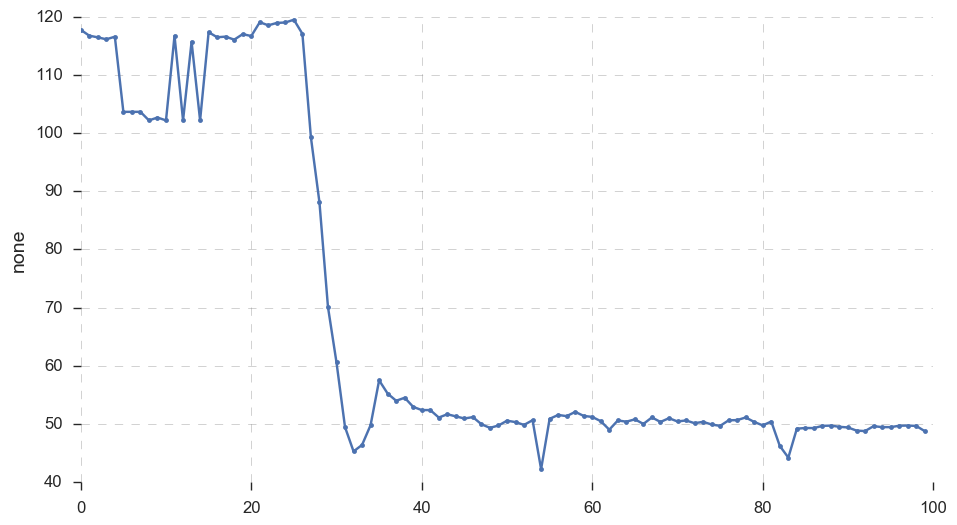

In [41]:
ipplot(xBuff)

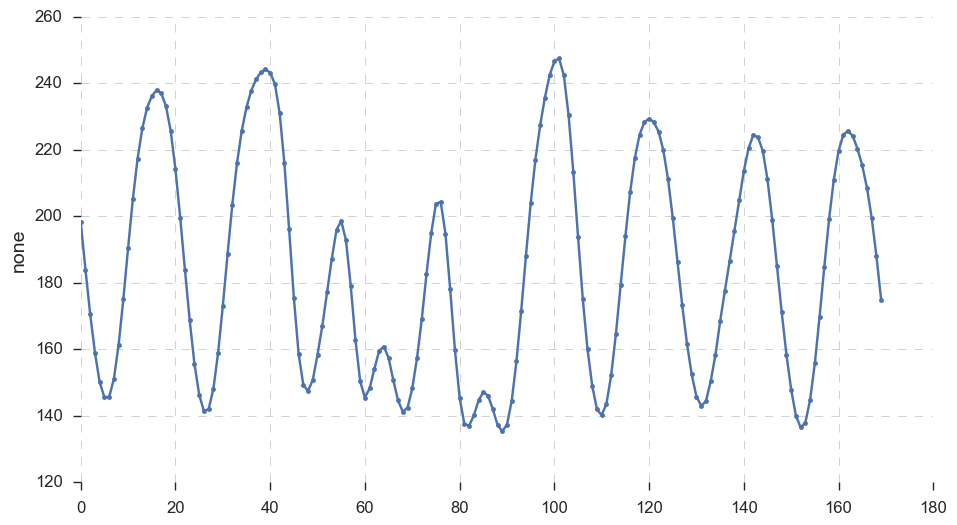

In [55]:
ipplot(filtY.tolist())

In [25]:
rng = pd.to_datetime(np.arange(len(yBuff))/fs,unit='ms')

In [4]:
%matplotlib notebook

In [27]:
np.arange(len(yBuff))/fs

array([  0.00000000e+00,   5.60000000e-02,   1.12000000e-01, ...,
         1.47196000e+03,   1.47201600e+03,   1.47207200e+03])

In [40]:
fudge  = (len(xBuff)/fs) / 878.

In [43]:
125/fs/fudge

4.174908703590993